# RL homework 2





## How to submit

Submissions in pairs only.

You should save a copy of the notebook to Google Drive and open it with Google Colab. Then answer all the questions inside the notebook, at the designated cells. Only the notebook will be submitted in moodle (in `.ipynb` format).

**Important:** All plots, results and outputs should be included in the notebook as the cells' outputs (run all cells and do not clear the output).
    
When you have completed the exercises and everything has finished running, click on 'File' in the menu-bar and then 'Download .ipynb'.

Then submit the downloaded '.ipynb' file to Moodle.

# The Assignment

### Part 1: Exploration vs. Exploitation

You will use Python to implement several bandit algorithms.
You will then run these algorithms on a multi-armed Bernoulli bandit problem, to understand the issue of balancing exploration and exploitation.

### Part 2: Model-based RL

You will use Python to implement the Dyna-Q agent with a replay buffer.
You will run the agent on a grid world and analyze the efficieny with respect to the number of steps in the environment.

# Setup

### Import Useful Libraries

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple
np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-notebook')

<ipython-input-32-b31fed65043d>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-notebook')


# Part 1: Exploration vs. Exploitation

### A generic multi-armed bandit class, with Bernoulli rewards

In [33]:
class BernoulliBandit(object):
  """A stationary multi-armed Bernoulli bandit."""

  def __init__(self, success_probabilities, success_reward=1., fail_reward=0.):
    """Constructor of a stationary Bernoulli bandit.

    Args:
      success_probabilities: A list or numpy array containing the probabilities,
          for each of the arms, of providing a success reward.
      success_reward: The reward on success (default: 1.)
      fail_reward: The reward on failure (default: 0.)
    """
    self._probs = success_probabilities
    self._number_of_arms = len(self._probs)
    self._s = success_reward
    self._f = fail_reward

  def step(self, action):
    """The step function.

    Args:
      action: An integer or tf.int32 that specifies which arm to pull.

    Returns:
      A sampled reward according to the success probability of the selected arm.

    Raises:
      ValueError: when the provided action is out of bounds.
    """
    if action < 0 or action >= self._number_of_arms:
      raise ValueError('Action {} is out of bounds for a '
                       '{}-armed bandit'.format(action, self._number_of_arms))

    success = bool(np.random.random() < self._probs[action])
    reward = success * self._s + (not success) * self._f
    return reward

### Helper functions

In [34]:
def smooth(array, smoothing_horizon=100., initial_value=0.):
  """smoothing function for plotting"""
  smoothed_array = []
  value = initial_value
  b = 1./smoothing_horizon
  m = 1.
  for x in array:
    m *= 1. - b
    lr = b/(1 - m)
    value += lr*(x - value)
    smoothed_array.append(value)
  return np.array(smoothed_array)

def one_hot(array, depth):
  """Multi-dimensional one-hot"""
  a = np.array(array)
  x = a.flatten()
  b = np.eye(depth)[x, :depth]
  return b.reshape(a.shape + (depth,))

def plot(algs, plot_data, optimal_value, repetitions=30):
  """Plot results of a bandit experiment."""
  algs_per_row = 3
  n_algs = len(algs)
  n_rows = (n_algs - 2)//algs_per_row + 1
  fig = plt.figure(figsize=(15, 5*n_rows))

  for i, p in enumerate(plot_data):
    for c in range(n_rows):
      ax = fig.add_subplot(n_rows, len(plot_data), i + 1 + c*len(plot_data))
      ax.grid(0)
      #ax.set_axis_bgcolor('white')

      current_algs = [algs[0]] + algs[c*algs_per_row + 1:(c + 1)*algs_per_row + 1]
      for alg in current_algs:
        data = p.data[alg.name]
        m = smooth(np.mean(data, axis=0))
        s = np.std(smooth(data.T).T, axis=0)/np.sqrt(repetitions)
        if p.log_plot:
          line = plt.semilogy(m, alpha=0.6, label=alg.name)[0]
        else:
          line = plt.plot(m, alpha=0.6, label=alg.name)[0]
          plt.fill_between(range(number_of_steps), m + s, m - s,
                           color=line.get_color(), alpha=0.2)
      if not p.log_plot:
        plt.plot([0, number_of_steps], [optimal_value]*2, '--k', label='optimal')

      plt.ylim(p.ylim)
      plt.title(p.title)
      if i == len(plot_data) - 1:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

def run_bandit_experiment(bandit, algs, repetitions):
  """Run multiple repetitions of a bandit experiment."""
  reward_dict = {}
  action_dict = {}

  for alg in algs:
    reward_dict[alg.name] = []
    action_dict[alg.name] = []

    for _ in range(repetitions):
      alg.reset()
      reward_dict[alg.name].append([])
      action_dict[alg.name].append([])
      action = None
      reward = None
      for i in range(number_of_steps):
        try:
          action = alg.step(action, reward)
        except:
          print(alg, action, reward)
          aoushd()
        reward = bandit.step(action)
        reward_dict[alg.name][-1].append(reward)
        action_dict[alg.name][-1].append(action)

  return reward_dict, action_dict

def train_agents(agents, number_of_arms, number_of_steps, repetitions=30,
                 success_reward=1., fail_reward=0.):

  success_probabilities = np.arange(0.25, 0.75 + 1e-6, 0.5/(number_of_arms - 1))
  bandit = BernoulliBandit(success_probabilities, success_reward, fail_reward)

  max_p = np.max(success_probabilities)
  min_p = np.min(success_probabilities)
  ylim_max = max_p*success_reward + (1 - max_p)*fail_reward
  ylim_min = min_p*success_reward + (1 - min_p)*fail_reward
  dif = ylim_max - ylim_min
  ylim = (ylim_min - 0.1*dif, ylim_max + 0.1*dif)

  max_prob = np.max(success_probabilities)
  optimal_value = max_prob*success_reward + (1 - max_prob)*fail_reward

  reward_dict, action_dict = run_bandit_experiment(bandit, agents, repetitions)

  smoothed_rewards = {}
  expected_rewards = {}
  regrets = {}
  for agent, rewards in reward_dict.items():
    smoothed_rewards[agent] = np.array(rewards)
  for agent, actions in action_dict.items():
    p_success = one_hot(actions, number_of_arms).dot(success_probabilities)
    expected_rewards[agent] = p_success*success_reward + (1 - p_success)*fail_reward
    regrets[agent] = optimal_value - expected_rewards[agent]

  PlotData = namedtuple('PlotData', ['title', 'data', 'log_plot', 'ylim'])
  plot_data = [
      PlotData(title='Smoohted rewards', data=smoothed_rewards,
               log_plot=False, ylim=ylim),
      PlotData(title='Expected rewards', data=expected_rewards,
               log_plot=False, ylim=ylim),
      PlotData(title='Current Regret', data=regrets,
               log_plot=True, ylim=(1e-2, 1)),
      PlotData(title='Total Regret',
               data=dict([(k, np.cumsum(v, axis=1)) for k, v in regrets.items()]),
               log_plot=False, ylim=(1e-0, 5e2)),
  ]

  plot(agents, plot_data, optimal_value)

### Random agent

In [35]:
class Random(object):
  """A random agent.

  This agent returns an action between 0 and 'number_of_arms',
  uniformly at random. The 'previous_action' argument of 'step'
  is ignored.
  """

  def __init__(self, number_of_arms):
    self._number_of_arms = number_of_arms
    self.name = 'random'
    self.reset()

  def step(self, previous_action, reward):
    return np.random.randint(self._number_of_arms)

  def reset(self):
    pass

# A1: Implement agents

Each agent, should implement the following methods:

### `step(self, previous_action, reward)`:
should update the statistics by updating the value for the previous_action towards the observed reward.

(Note: make sure this can handle the case that previous_action=None, in which case no statistics should be updated.)

(Hint: you can split this into two steps: 1. update values, 2. get new action.  Make sure you update the values before selecting a new action.)

### `reset(self)`:
resets statistics (should be equivalent to constructing a new agent from scratch).  
**Note:** Make sure that the initial values (after a reset) are all zero.

### `__init__(self)`:
The `__init__` can be *the same* as for the random agent above (with the exception of $\epsilon$-greedy---see below), except for the name, which should be unique (e.g., 'greedy', 'ucb', etc.)

All agents should be in pure Python - so you cannot use TensorFlow to, e.g., compute gradients.  Using `numpy` is fine.



## Agent 1: greedy
**[5 pts]** You should **implement the greedy** agent, that

1.   Estimates the average reward for each action that was selected so far, and
2.   Always selects the highest-valued action.


In [36]:
class Greedy(object):

  def __init__(self, number_of_arms):
    self._number_of_arms = number_of_arms
    self.name = 'Greedy'
    self.reset()

  def reset(self):
    """TODO: Implement"""
    self._actions_values = np.zeros(self._number_of_arms)
    self._actions_num = np.zeros(self._number_of_arms)

  def step(self, previous_action, reward):
    """TODO: Implement"""
    if previous_action is not None:
      delta = reward - self._actions_values[previous_action]
      self._actions_values[previous_action]+= delta/(self._actions_num[previous_action]+1)
      self._actions_num[previous_action] += 1

    action = np.argmax(self._actions_values)
    return action




## Agent 2: $\epsilon$-greedy
**[5 pts]** You should **implement an $\epsilon$-greedy** agent, that selects the highest-valued action with probability $1 - \epsilon$, and otherwise selects an action at random.

The exploration parameter $\epsilon$ should be given in the `__init__`, as indicated in the code below.


In [37]:

class EpsilonGreedy(object):

  def __init__(self, number_of_arms, epsilon=0.1):
    self._number_of_arms = number_of_arms
    self._epsilon = epsilon
    self.name = 'Epsilon-greedy epsilon:{}'.format(epsilon)
    self.reset()

  def reset(self):
    """TODO: Implement"""
    self._actions_num = np.zeros(self._number_of_arms)
    self._actions_values = np.zeros(self._number_of_arms)

  def step(self, previous_action, reward):
    """TODO: Implement"""
    if previous_action is not None:
      delta = reward - self._actions_values[previous_action]
      self._actions_values[previous_action]+= delta/(self._actions_num[previous_action]+1)
      self._actions_num[previous_action] += 1

    if np.random.rand() >= self._epsilon:
      action = np.argmax(self._actions_values)
    else:
      action = np.random.randint(self._number_of_arms)

    return action



## Agent 3: UCB
**[10 pt]** You should **implement** an agent that **explores with UCB**.


In [38]:
class UCB(object):

  def __init__(self, number_of_arms):
    self._number_of_arms = number_of_arms
    self.name = 'UCB'
    self.reset()


  def reset(self):
    """TODO: Implement"""
    self._actions_num = np.zeros(self._number_of_arms)
    self._actions_values = np.zeros(self._number_of_arms)
    self._total_steps = 0

  def step(self, previous_action, reward):
    """TODO: Implement"""
    self._total_steps += 1
    if previous_action is not None:
      self._actions_num[previous_action] += 1
      self._actions_values[previous_action] += reward


    ucb_values = []
    for arm in range(self._number_of_arms):
      if self._actions_num[arm] == 0:
        ucb_values.append(float('inf'))
      else:
        average_reward = self._actions_values[arm] / self._actions_num[arm]
        confidence = np.sqrt(2 * np.log(self._total_steps)/self._actions_num[arm])
        ucb_values.append(average_reward + confidence)

    action = int(np.argmax(ucb_values))

    return action




## Agent 4: REINFORCE agents
You should implement agents that implement REINFORCE policy-gradient methods. We went over REINFORCE in the context of full MDPs, but it can also be implemented in a multi-armed bandit setup.  

The policy should be parameterized using action preferenes $p$, using a softmax on top:
$$\pi(a) = \frac{\exp(p(a))}{\sum_b \exp(p(b))}\,.$$

The action preferences are stored separately, so that for each action $a$ the preference $p(a)$ is a single value that you directly update.



## Assignment 4a:
In the next text field, write down the update function to the preferences for all actions $\{a_1, \ldots, a_n\}$ if you selected a specific action $A_t = a_i$ and received a reward of $R_t$.

In other words, complete:
\begin{align*}
p_{t+1}(a)
& = \ldots
&& \text{for $a = A_t$} \\
p_{t+1}(b)
& = \ldots
&& \text{for all $b \ne A_t$}
\end{align*}

**[10 pts]** **Instructions**: please provide answer in markdown/latex below.

$
  p_{t+1}(a) = p_t(a) + \alpha \cdot (R_t -\bar{R}_t) \cdot (1- \pi_t(a))\ \ \  
  for\ a=A_t $

$
 p_{t+1}(b) = p_t(b) - \alpha \cdot (R_t -\bar{R}_t) \cdot \pi_t(b) \ \ \ for \ all \ b \neq A_t $



$ \bar{R}_t \ is \ baseline \ reward $



## Assignment 4b:
**[10 pts]** You should implement a **vanilla REINFORCE** agent **with** and **without** a **baseline**. Implement the baseline as a state value (rembember the baseline should be independent of actions).

Whether or not a baseline is used should be a boolean constructor argument.

In [39]:
class REINFORCE(object):

  def __init__(self, number_of_arms, step_size=0.1, baseline=False):
    self._number_of_arms = number_of_arms
    self._lr = step_size
    self.name = 'REINFORCE, baseline: {}'.format(baseline)
    self._baseline = baseline
    self.reset()

  def reset(self):
    """TODO: Implement"""
    self._preferences = np.zeros(self._number_of_arms)
    self._average_reward = 0
    self._total_selected = 0

  def step(self, previous_action, reward):
    """TODO: Implement"""
    if previous_action is None:
      action = np.random.randint(self._number_of_arms)
    else:
      if self._baseline:
        self._total_selected+=1
        self._average_reward += (reward - self._average_reward)/self._total_selected
      exp_preferences = np.exp(self._preferences)
      action_probs = exp_preferences/np.sum(exp_preferences)
      action = np.random.choice(range(self._number_of_arms),p=action_probs)

      advantage = reward - self._average_reward if self._baseline else reward
      for a in range(self._number_of_arms):
        if a==previous_action:
          self._preferences[a]+=self._lr*advantage*(1-action_probs[a])
        else:
          self._preferences[a]-=self._lr*advantage*action_probs[a]
    return action





# Assignment 5: Analyse Results

### Run the cell below to train the agents and generate the plots for the first experiment.

Trains the agents on a Bernoulli bandit problem with 5 arms,
with a reward on success of 1, and a reward on failure of 0.

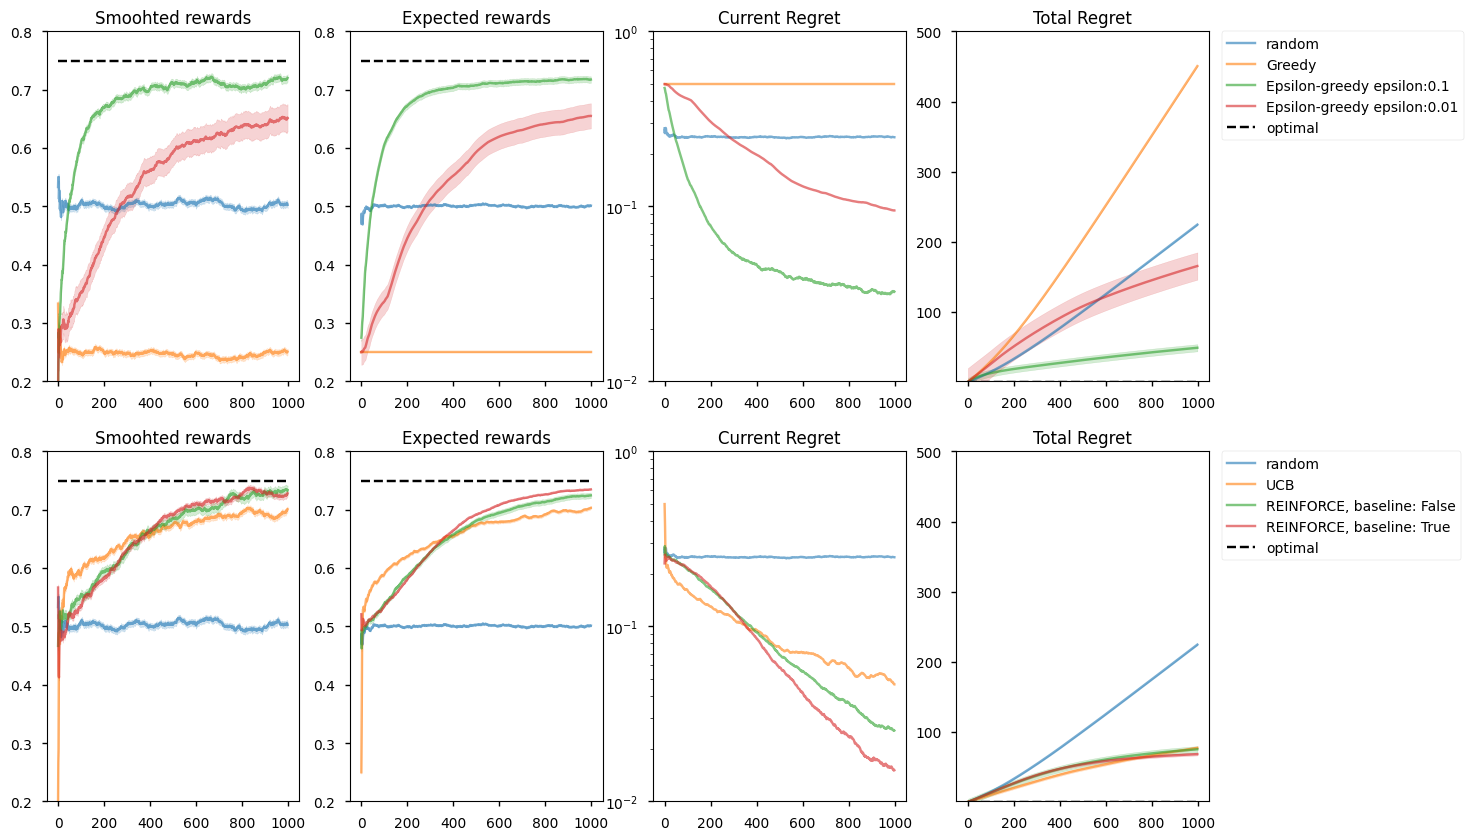

In [31]:
#@title Experiment 1: Bernoulli bandit

number_of_arms = 5
number_of_steps = 1000

agents = [
    Random(number_of_arms),
    Greedy(number_of_arms),
    EpsilonGreedy(number_of_arms, 0.1),
    EpsilonGreedy(number_of_arms, 0.01),
    UCB(number_of_arms),
    REINFORCE(number_of_arms),
    REINFORCE(number_of_arms, baseline=True),
]

train_agents(agents, number_of_arms, number_of_steps)

## Assignment 5 a.
(Answer inline in the markdown below each question.)

**[5pts]** Name the best and worst algorithms, and explain (with one or two sentences each) why these are best and worst.

-The best algorithm is Reinforce algorithm with baseline because it effectively balances exploration and exploitation.It have higher rewards and lower regret compared to others.

-The worst algorithm is Greedy algorithm because it always selects the action with the highest estimated value without considering exploration.It have lower rewards and higher regret compared to other algorithms.

**[5pts]** Which algorithms are guaranteed to have linear total regret?

-Algorithms that are guaranteed to have linear regret are:
Random , Greedy

**[5pts]** Which algorithms are guaranteed to have logarithmic total regret?

-Algorithms that are guaranteed to logarithmic total regret is UCB.

**[5pts]** Which of the $\epsilon$-greedy algorithms performs best?  Which should perform best in the long run?

-Epsilon greedy algorithm that performs best is the one with epsilon=0.1.
Epsilon greedy algorithm that performs best in the long run is the one with epsilon=0.01.


### Run the cell below to train the agents and generate the plots for the second experiment.

Trains the agents on a bernoulli bandit problem with 5 arms,
with a reward on success of 0, and a reward on failure of -1.

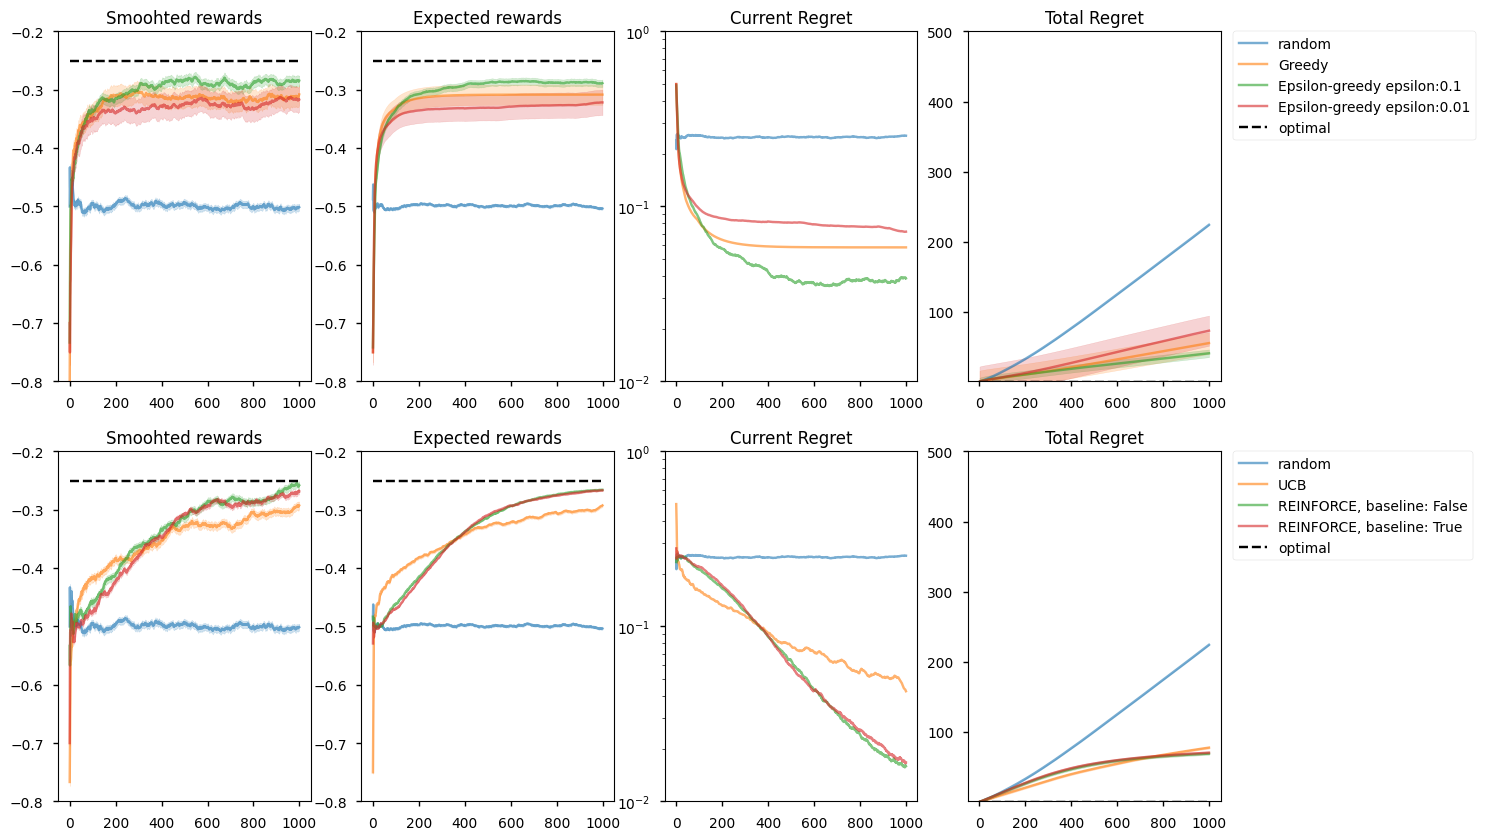

In [ ]:
#@title Experiment 2: R = 0 on success, R = -1 on failure.
number_of_arms = 5
number_of_steps = 1000

train_agents(agents, number_of_arms, number_of_steps,
             success_reward=0., fail_reward=-1.)

## Assignment 5 b.
(Answer inline in markdown.)

**[10pts]** Explain which algorithms improved from the changed rewards, and why.

(Use at most two sentences per algorithm and feel free to combine explanations for different algorithms where possible).

-The algorithms that been improved from the changed rewards:
1.Greedy Algorithm - we can identify from the results that the regret have been obviouslly decreased and the reward have been changed from constant reward to an increased reward by increasing steps number.
2.Epsilon-greedy epsilon=0.01 - as we can identify from the results that the regret have been decreased and the reward have been increased.


# Part 2: Model-based RL

### A grid world

In [10]:
class Grid(object):

  def __init__(self, noisy=False):
    # -1: wall
    # 0: empty, episode continues
    # other: number indicates reward, episode will terminate
    self._layout = np.array([
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0, -1, -1, -1,  0,  0,  0, -1],
      [-1,  0,  0,  0, -1, -1, -1,  0, 10,  0, -1],
      [-1,  0,  0,  0, -1, -1, -1,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
    ])
    self._start_state = (2, 2)
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._noisy = noisy

  @property
  def number_of_states(self):
      return self._number_of_states

  def plot_grid(self):
    plt.figure(figsize=(4, 4))
    plt.imshow(self._layout > -1, interpolation="nearest", cmap='pink')
    ax = plt.gca()
    ax.grid(0)
    plt.xticks([])
    plt.yticks([])
    plt.title("The grid")
    plt.text(2, 2, r"$\mathbf{S}$", ha='center', va='center')
    plt.text(8, 3, r"$\mathbf{G}$", ha='center', va='center')
    h, w = self._layout.shape
    for y in range(h-1):
      plt.plot([-0.5, w-0.5], [y+0.5, y+0.5], '-k', lw=2)
    for x in range(w-1):
      plt.plot([x+0.5, x+0.5], [-0.5, h-0.5], '-k', lw=2)


  def get_obs(self):
    y, x = self._state
    return y*self._layout.shape[1] + x

  def obs_to_state(obs):
    x = obs % self._layout.shape[1]
    y = obs // self._layout.shape[1]
    s = np.copy(grid._layout)
    s[y, x] = 4
    return s

  def step(self, action):
    y, x = self._state

    if action == 0:  # up
      new_state = (y - 1, x)
    elif action == 1:  # right
      new_state = (y, x + 1)
    elif action == 2:  # down
      new_state = (y + 1, x)
    elif action == 3:  # left
      new_state = (y, x - 1)
    else:
      raise ValueError("Invalid action: {} is not 0, 1, 2, or 3.".format(action))

    new_y, new_x = new_state
    if self._layout[new_y, new_x] == -1:  # wall
      reward = -5.
      discount = 0.9
      new_state = (y, x)
    elif self._layout[new_y, new_x] == 0:  # empty cell
      reward = 0.
      discount = 0.9
    else:  # a goal
      reward = self._layout[new_y, new_x]
      discount = 0.
      new_state = self._start_state
    if self._noisy:
      width = self._layout.shape[1]
      reward += 2*np.random.normal(0, width - new_x + new_y)

    self._state = new_state

    return reward, discount, self.get_obs()

### Helper functions

In [11]:
def run_experiment(env, agent, number_of_steps):
    try:
      action = agent.initial_action()
    except AttributeError:
      action = 0
    for i in range(number_of_steps):
      reward, discount, next_state = grid.step(action)
      action = agent.step(reward, discount, next_state)

def random_policy(q):
  return np.random.randint(4)

def plot_values(values, colormap='pink', vmin=0, vmax=10):
  plt.imshow(values, interpolation="nearest", cmap=colormap, vmin=vmin, vmax=vmax)
  plt.yticks([])
  plt.xticks([])
  plt.colorbar(ticks=[vmin, vmax])


## Dyna-Q with experience replay

**[20 pts]** Since the environment is a simple deterministic grid world, we will implement the model as an **Experience Replay Buffer**. This means we will store every transition $(S, A, R, \gamma, S')$ from the real environment in the buffer, and then extract random transitions to train the agent. The reason this can be considered a model is that the transitions in the replay buffer serve as a mapping from $(S, A)$ pairs to the values of $(R, \gamma, S')$. The reason we store $\gamma$ is to detect the goal state (see below).

More precisely, to learn action values, at each step:
* select actions according to the behaviour policy
* accumulate all observed transitions $(S, A, R, \gamma, S')$  in the environment in a *replay buffer*,
* apply an online Q-learning
* apply multiple Q-learning updates based on transitions sampled (uniformly) from the *replay buffer* (in addition to the online updates).

In pseudo-code:

**Initialize** $Q(s, a)$, and $\text{ReplayBuffer}$

**Loop**:

1. $S \gets{}$current (nonterminal) state

2. $A \gets{} $sample action from behaviour policy

3. Take action $A$; observe resultant reward $R$, discount $\gamma$, and state, $S'$

4. $Q(S, A) \gets Q(S, A) + \alpha (R + \gamma \max_a Q(S', a) − Q(S, A))$

5. $\text{ReplayBuffer}.\text{append_transition}(S, A, R, \gamma, S')$

6. repeat n times:

  1. $S, A, R, \gamma, S' \gets \text{ReplayBuffer}.\text{sample_transition}()$
  
  4. $Q(S, A) \gets Q(S, A) + \alpha (R + \gamma \max_a Q(S', a) − Q(S, A))$

### A note on the behaviour policy
Assume a behaviour policy object is given in the constructor which can be used to sample actions given the Q values. So you can use it as follows:
```
action = self._behaviour_policy(self._q_values[next_state])
```

### A note on the discount factor
When the discount is zero ($\text{discount} = \gamma = 0$), then the `next_observation` will be the initial observation of the next episode.  One shouldn't bootstrap on the value of this state, which can simply be guaranteed when using "$\gamma \cdot v(\text{next_observation})$" (for whatever definition of $v$ is appropriate) in the update, because $\gamma = 0$.  So, the end of an episode can be seamlessly handled with the same step function.


### A note on the initial action
Normally, you would also have to implement a method that gives the initial action, based on the initial state.  As in the previous assignment you can use the action `0` (which corresponds to `up`) as initial action, so that otherwise we do not have to worry about this.  Note that this initial action is only executed once, and the beginning of the first episode---not at the beginning of each episode.

Q-learning and it's variants needs to remember the last action in order to update its value when they see the next state.  In the `__init__`, make sure you set the initial action to zero, e.g.,
```
def __init__(...):
  (...)
  self._action = 0
  (...)
```


In [14]:
class DynaQ(object):

  def __init__(
      self, number_of_states, number_of_actions, initial_state,
      behaviour_policy, num_offline_updates=0, step_size=0.1):
    """TODO: Implement"""
    self._q_values = np.zeros((number_of_states, number_of_actions))
    self._replay_buffer = []
    self._number_of_actions = number_of_actions
    self._state = initial_state
    self._behaviour_policy = behaviour_policy
    self._num_offline_updates = num_offline_updates
    self._step_size = step_size
    self._action = 0
    return

  @property
  def q_values(self):
    return self._q_values

  def step(self, reward, discount, next_state):
    """TODO: Implement"""
    max_q = np.max(self._q_values[next_state])
    self._q_values[self._state, self._action]+= self._step_size * (reward + discount*max_q - self._q_values[self._state,self._action])
    self._replay_buffer.append((self._state, self._action,reward,discount,next_state))

    for _ in range(self._num_offline_updates):
      i = np.random.randint(len(self._replay_buffer))
      s, a, r, gamma, s_tag = self._replay_buffer[i]
      max_q_stag = np.max(self._q_values[s_tag])
      self._q_values[s, a] += self._step_size * (r+gamma*max_q_stag - self._q_values[s,a])

    self._state = next_state
    self._action = self._behaviour_policy(self._q_values[next_state])
    action = self._action


    return action

## Analyse results.

We will compare the performance of vanilla Q-learning and DynaQ with 100 of offline updates per setp (updates from the replay buffer).

Vanilla Q-learning can be implemented by setting the number of offline updates to zero.

Run the following cell and answer the question.


Q-learning value at init state 0.0
dyna-Q value at init state 3.5149316368716232


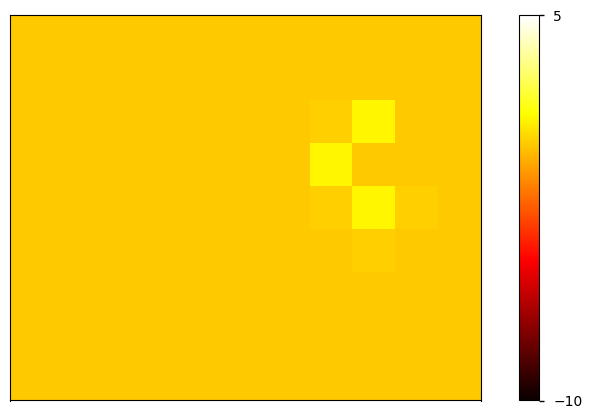

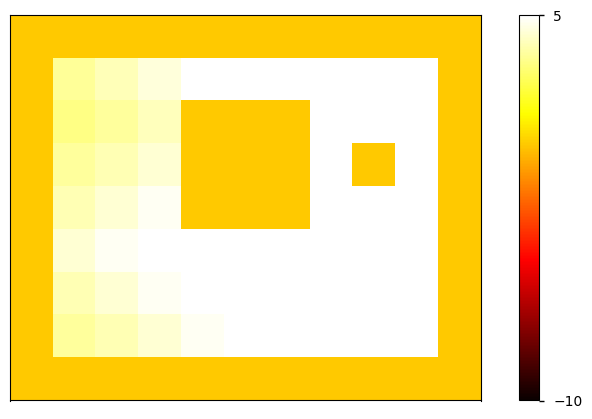

In [17]:
# start environment
grid = Grid()
init_state = grid.get_obs()

behaviour_policy = random_policy # uniform random that does not depend on Q

# start agents
agents = [
    DynaQ(grid._layout.size, 4, grid.get_obs(),
                behaviour_policy, num_offline_updates=0, step_size=0.1),
    DynaQ(grid._layout.size, 4, grid.get_obs(),
                behaviour_policy, num_offline_updates=100, step_size=0.1),
]

agent_names = ["Q-learning", "dyna-Q"]

for a in range(len(agents)):
  # restart environment
  grid = Grid()

  # run expriments and get Q-values.
  run_experiment(grid, agents[a], int(1e3))

  # compute the one-step greedy state values
  v = np.max(agents[a].q_values, axis=1)

  # show results
  plt.figure(figsize=(10,5))
  plot_values(v.reshape(grid._layout.shape), colormap="hot", vmin=-10, vmax=5)
  print(agent_names[a], 'value at init state', v[init_state])

**[10 pts]** Explain the difference between the two runs.

(Answer inline in markdown).

The difference between the two runs:
In the first run there is no offline updates,this means that the agent updates it's q values based on immediate rewards it receives in real time, without looking back at past experiences.
On the other hand, in the second run the offline updates num is 100,that means that the agent performs 100 offline updates per step.It's means that in addition to online updates the agent updates it's q values using transitions sampled from replay buffer.It learns from both present and past and that leads to better decision making.
